In [1]:
import torch
torch.manual_seed(0)
from tangermeme.io import extract_loci
from bpnetlite.io import PeakGenerator, DataGenerator
from custom_bpnet_test import customBPNet
import random
import os
import utility_loader
import h5py
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
training_data = utility_loader.bpnet_DataLoader(
	hdf5_tensor="/data/mariani/specificity_bpnet/folds/thresh_10/fold_0/train_data_fold_0.hdf5", 
	in_window=2114, out_window=1000, random_state=0, num_workers=4, 
	batch_size=512, max_jitter=128, reverse_complement=True,shuffle=True
)

valid_data = utility_loader.bpnet_DataLoader(
	hdf5_tensor="//data/mariani/specificity_bpnet/folds/thresh_10/fold_0/validation_data_fold_0.hdf5", 
	in_window=2114, out_window=1000, random_state=0, num_workers=4, 
	batch_size=512, max_jitter=0, reverse_complement=False
)

test_data = utility_loader.bpnet_DataLoader(
	hdf5_tensor="/data/mariani/specificity_bpnet/folds/thresh_10/fold_0/test_data_fold_0.hdf5", 
	in_window=2114, out_window=1000, random_state=0, num_workers=4, 
	batch_size=512, max_jitter=0, reverse_complement=False
)

In [3]:
# Data dictionary to control model configuration
dict_data = {
	"n_outputs":22,
	"n_control_tracks":2,
	"trimming":(2114-1000)//2, # difference between the input length and the output length, actually half of that.
	"alpha": 0.5, #0.5
	"n_filters": 64,
	"n_layers":8,
	"name": "multiple_counts"
}

model = customBPNet(**dict_data).cuda()
# Switch to AdamW?
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=1e-2) # increase it in the beginning now that I use a scheduler
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)	
#weight decay has been chosen based on https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, cooldown=2, patience=4)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(training_data), epochs=30)


In [ ]:
model.fit(
	training_data, optimizer, scheduler,
	valid_data=valid_data, batch_size=1024, 
	max_epochs=2, validation_iter=50, early_stopping=15*3)

In [8]:
loaded_model = customBPNet(**dict_data).cuda()
loaded_model.load_state_dict(torch.load('/data/mariani/specificity_bpnet/code/wider_context_n_layers_13.torch', weights_only = True))

<All keys matched successfully>

In [9]:
loaded_model.predict(
	test_data,batch_size=1024
)

Test MNLL	Test Profile Pearson	Test Count Pearson	Test Count MSE


1130.0415	0.09756739	0.5814589	2.04


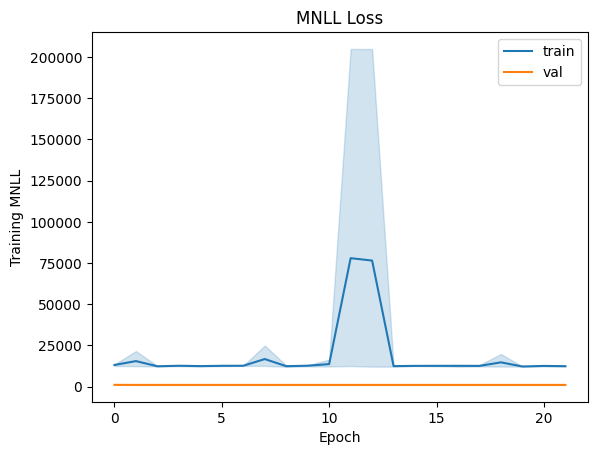

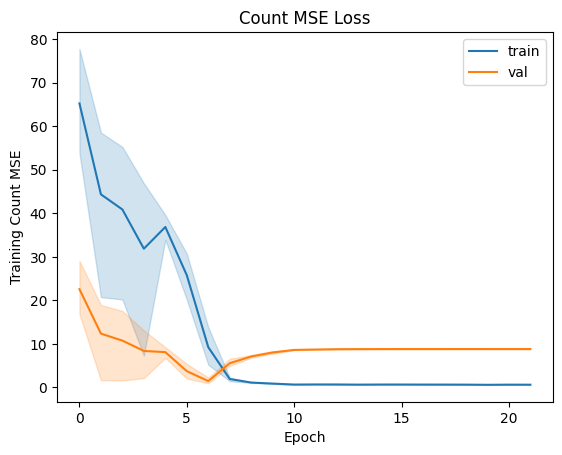

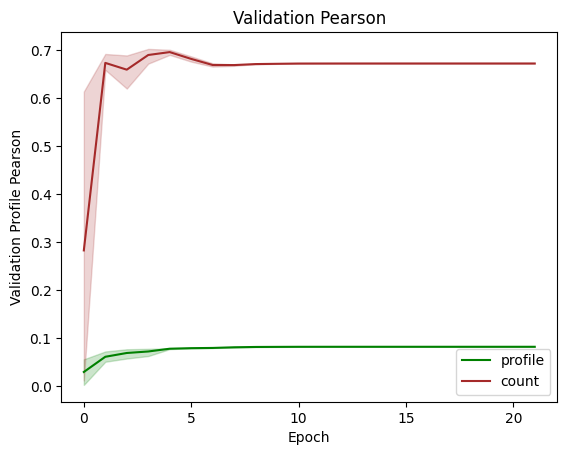

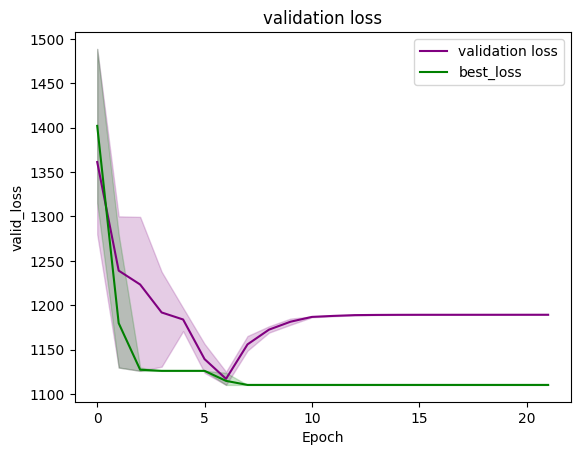

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

log = pd.read_table("/data/mariani/specificity_bpnet/code/wider_context.log")

sns.lineplot(data=log, x="Epoch", y="Training MNLL", label="train")
sns.lineplot(data=log, x="Epoch", y="Validation MNLL", label="val")
plt.title("MNLL Loss")
plt.show()

sns.lineplot(data=log, x="Epoch", y="Training Count MSE", label="train")
sns.lineplot(data=log, x="Epoch", y="Validation Count MSE", label="val")
plt.title("Count MSE Loss")
plt.show()

sns.lineplot(data=log, x="Epoch", y="Validation Profile Pearson", color="green", label="profile")
sns.lineplot(data=log, x="Epoch", y="Validation Count Pearson", color="brown", label="count")
plt.title("Validation Pearson")
plt.show()

sns.lineplot(data=log, x="Epoch", y="valid_loss", color="purple", label="validation loss")
sns.lineplot(data=log, x="Epoch", y="best_loss", color="green", label="best_loss")
plt.title("validation loss")
plt.show()